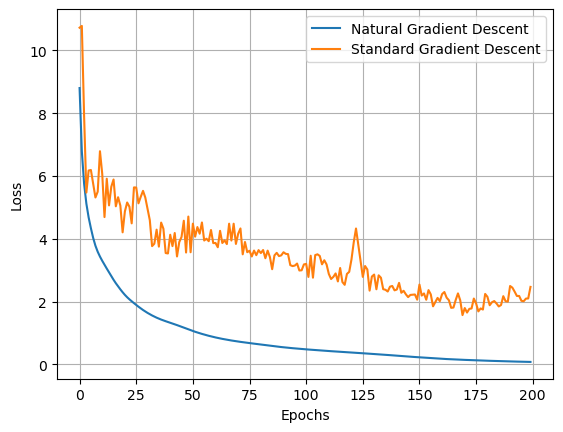

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

num_samples = 100   # Size of sample
num_epochs = 200    # Number of iterations
dim_x = 20          # Number of neurons in the input layer
hidden_dim = 10     # Number of neurons in the hidden layer
noise_std = 0.1     # Noise variance
learning_rate = 0.1 # Learning rate (assumed constant)

w_in_true = np.random.randn(dim_x, hidden_dim)  # Best weights from input to hidden layer
w_out_true = np.random.randn(hidden_dim)        # Best weights from hidden layer to output

x_data = np.random.randn(num_samples, dim_x)              # Input data
noise = np.random.normal(0, noise_std, size=num_samples)  # Random noise

def activation_function(x):
    return np.tanh(x)

def generate_outputs(x_data, w_in_true, w_out_true, noise):
    hidden_output = activation_function(x_data @ w_in_true)  
    z = hidden_output @ w_out_true + noise                   
    return z

z_data = generate_outputs(x_data, w_in_true, w_out_true, noise) # Output data

w_in_nat = np.random.randn(dim_x, hidden_dim)  # Weights initialization for natural gradient (input to hidden)
w_out_nat = np.random.randn(hidden_dim)        # Weights initialization for natural gradient (hidden to output)

w_in_std = np.random.randn(dim_x, hidden_dim)  # Weights initialization for natural gradient (input to hidden)
w_out_std = np.random.randn(hidden_dim)        # Weights initialization for natural gradient (hidden to output)


losses_nat = []    # Full loss for natural gradient

losses_std = []    # Full loss for standard gradient

##### On-line Learning Procedure (with an extra loop over the epochs) #####

for epoch in range(num_epochs):
    
    for t in range(num_samples):
    
        x_i = x_data[t]
        z_i = z_data[t]
    
    ######## Natural Gradient ########
        hidden_nat = activation_function(x_i @ w_in_nat)
        z_pred_nat = hidden_nat @ w_out_nat
        error_nat = z_i - z_pred_nat
        grad_out_nat = -error_nat * hidden_nat             # Gradient for output weights

        grad_hidden_nat = -error_nat * w_out_nat * (1 - hidden_nat**2) 
        grad_in_nat = np.outer(x_i, grad_hidden_nat)       # Gradient for hidden weights

        fisher_matrix_out = np.outer(hidden_nat, hidden_nat) + 1e-6 * np.eye(hidden_dim)
        natural_grad_out = np.linalg.pinv(fisher_matrix_out) @ grad_out_nat

        fisher_matrix_in = sum(np.outer(x_i, x_i) * w_out_nat[j]**2 * (1 - hidden_nat[j]**2) for j in range(hidden_dim)) + 1e-6 * np.eye(dim_x)
        natural_grad_in = np.linalg.pinv(fisher_matrix_in) @ grad_in_nat

        w_out_nat -= learning_rate * natural_grad_out
        w_in_nat -= learning_rate * natural_grad_in

    ######## Standard Gradient ########
        hidden_std = activation_function(x_i @ w_in_std)
        z_pred_std = hidden_std @ w_out_std
        error_std = z_i - z_pred_std
        grad_out_std = -error_std * hidden_std         # Gradient for output weights

        grad_hidden_std = -error_std * w_out_std * (1 - hidden_std**2)
        grad_in_std = np.outer(x_i, grad_hidden_std)  # Gradient for hidden weights

        w_out_std -= learning_rate * grad_out_std
        w_in_std -= learning_rate * grad_in_std

    z_pred_full_nat = generate_outputs(x_data, w_in_nat, w_out_nat, np.zeros(num_samples))
    total_loss_nat = np.mean((z_data - z_pred_full_nat)**2)
    losses_nat.append(total_loss_nat)
    
    z_pred_full_std = generate_outputs(x_data, w_in_std, w_out_std, np.zeros(num_samples))
    total_loss_std = np.mean((z_data - z_pred_full_std)**2)
    losses_std.append(total_loss_std)

##### PLOT #####

t = np.arange(0, num_epochs)
plt.plot(t, losses_nat, label="Natural Gradient Descent")
plt.plot(t, losses_std, label="Standard Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
#plt.savefig("loss1.png", dpi=300)
plt.show()
